In [10]:
from ultralytics import YOLO
model = YOLO('yolov8n-seg.pt') 
print(model)


ModuleNotFoundError: No module named 'ultralytics'

In [1]:
#load and vis a few seqmented images in the images_CNN folder

import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import Image, ImageSequence
img_list = glob.glob('images_CNN/F?_im.TIF')+glob.glob('images_CNN/F??_im.TIF')
img_list = sorted(img_list)
mask_list = glob.glob('images_CNN/*mask.h5')
mask_list = sorted(mask_list)
fluo_gfp = glob.glob('images_CNN/*GFP_im.TIF')
fluo_gfp = sorted(fluo_gfp)

fluo_rfp = glob.glob('images_CNN/*RFP_im.TIF')
fluo_rfp = sorted(fluo_rfp)

print( len(img_list), len(mask_list) , len(fluo_gfp), len(fluo_rfp  )   )

dataset = {}
for i in range(len(img_list)):
    dataset[i] = { 'img': img_list[i], 'mask': mask_list[i], 'gfp': fluo_gfp[i], 'rfp': fluo_rfp[i]  }
print(dataset)

11 11 11 11
{0: {'img': 'images_CNN/F10_im.TIF', 'mask': 'images_CNN/F10_mask.h5', 'gfp': 'images_CNN/F10_GFP_im.TIF', 'rfp': 'images_CNN/F10_RFP_im.TIF'}, 1: {'img': 'images_CNN/F11_im.TIF', 'mask': 'images_CNN/F11_mask.h5', 'gfp': 'images_CNN/F11_GFP_im.TIF', 'rfp': 'images_CNN/F11_RFP_im.TIF'}, 2: {'img': 'images_CNN/F1_im.TIF', 'mask': 'images_CNN/F1_mask.h5', 'gfp': 'images_CNN/F1_GFP_im.TIF', 'rfp': 'images_CNN/F1_RFP_im.TIF'}, 3: {'img': 'images_CNN/F2_im.TIF', 'mask': 'images_CNN/F2_mask.h5', 'gfp': 'images_CNN/F2_GFP_im.TIF', 'rfp': 'images_CNN/F2_RFP_im.TIF'}, 4: {'img': 'images_CNN/F3_im.TIF', 'mask': 'images_CNN/F3_mask.h5', 'gfp': 'images_CNN/F3_GFP_im.TIF', 'rfp': 'images_CNN/F3_RFP_im.TIF'}, 5: {'img': 'images_CNN/F4_im.TIF', 'mask': 'images_CNN/F4_mask.h5', 'gfp': 'images_CNN/F4_GFP_im.TIF', 'rfp': 'images_CNN/F4_RFP_im.TIF'}, 6: {'img': 'images_CNN/F5_im.TIF', 'mask': 'images_CNN/F5_mask.h5', 'gfp': 'images_CNN/F5_GFP_im.TIF', 'rfp': 'images_CNN/F5_RFP_im.TIF'}, 7: {'i

In [2]:

import skimage.measure as measure
import copy

def output_contours( m , c , verbose = False):
    contours = measure.find_contours(m, .9)
    if verbose:
        plt.imshow(m)
        
        print( np.unique(m))

        for n, contour in enumerate(contours):
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
        plt.show()

    #output contours of each mask to file
    #divide x and y coordinates by total image size
    #to get values between 0 and 1  
    #<class-index> <x1> <y1> <x2> <y2> ... <xn> <yn>
    lines = []
    for c in contours:
        coords = []
        for i in range(c.shape[0]):
            coords.append(c[i][1] / m.shape[1])
            coords.append(c[i][0] / m.shape[0])
        line = str(c) + ' ' + ' '.join([str(c) for c in coords]) + '\n'
        lines.append(line)
    return lines

def split_mask(mask):
    #custom encoding with 3 classes
    mask1 = copy.deepcopy(mask)
    mask1[ (mask1 > 0) & (mask1 < 1000)] =  1
    mask1[mask1 > 1] = 0 

    mask2 = copy.deepcopy(mask)
    mask2[mask2 == 1] = 0
    mask2[ (mask2 > 1000) & (mask2 < 2000)] =  1
    mask2[mask2 > 1] = 0

    mask3 = copy.deepcopy(mask)
    mask3[mask3 == 1] = 0
    mask3[ (mask3 >= 2000) ] =  1
    mask3[mask3 > 1] = 0
    return mask1, mask2, mask3

def mask2contourfile( mask , outputfile , verbose = False):
    m1, m2, m3 = split_mask(mask)
    lines = output_contours(m1, 1 , verbose = verbose)
    lines += output_contours(m2, 2, verbose = verbose)
    lines += output_contours(m3, 3, verbose = verbose)
    with open(outputfile, 'w') as f:
        f.writelines(lines)
    return  outputfile


In [3]:
#clean finaldataset folder
import shutil
try:
    shutil.rmtree('./images_CNN/Finaldataset')
except:
    pass
os.mkdir('./images_CNN/Finaldataset/')
os.mkdir('./images_CNN/Finaldataset/images/')
os.mkdir('./images_CNN/Finaldataset/labels/')


0 {'img': 'images_CNN/F10_im.TIF', 'mask': 'images_CNN/F10_mask.h5', 'gfp': 'images_CNN/F10_GFP_im.TIF', 'rfp': 'images_CNN/F10_RFP_im.TIF'}
FOV0
T0
T1
T2
T3
T4
T5
[   0    1    2    3    4 1002 1003 1004 1005 1006 1007 1008 1009 1010
 1011 1012 1013 1014 1015 1016 1017 1018 1020 1021 1023 1024 1025 1026
 1027 1028 1029 2001 2002 2003]


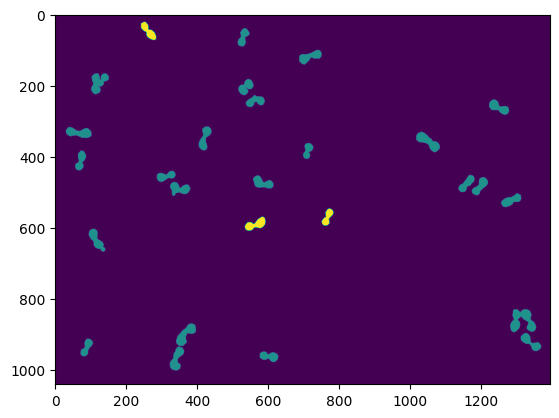

[0 1]


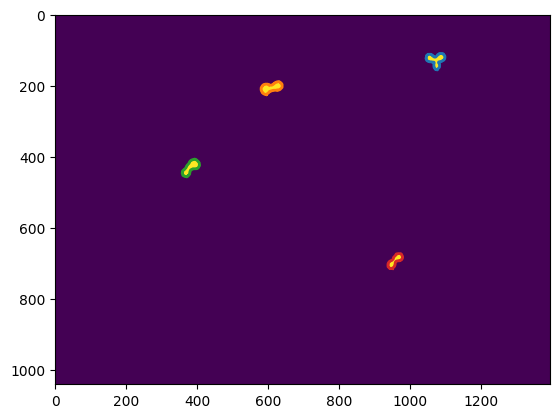

[0 1]


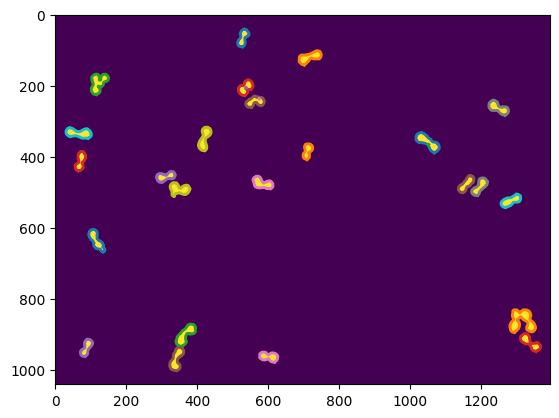

[0 1]


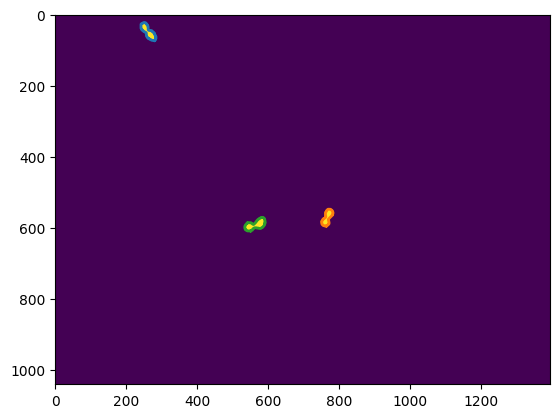

loading img
loading gfp
loading rfp


 43%|████▎     | 3/7 [04:19<06:09, 92.50s/it]

In [4]:
#stack equivalent frames together from img, gfp and rfp and transform them to a jpg image
import cv2
import numpy as np
import os
import tqdm

def yield_frames(img):
    for i, page in enumerate(ImageSequence.Iterator(img)):
        yield np.array(page)

count = 0 
for sample in dataset:
    print(sample, dataset[sample])
    maskfile = dataset[sample]['mask']
    maskh5 = h5py.File(maskfile, 'r')
    for group in maskh5.keys():
        print(group)
        for frame in maskh5[group]:
            print(frame)
            mask = np.array( maskh5[group][frame] ,  dtype = np.uint16 )
            if np.sum(mask) > 0 :
                print(np.unique(mask) )
                plt.imshow(mask)
                plt.show()
                converted = mask2contourfile(mask, maskfile +'converted.txt' , verbose = True)
                dataset[sample]['mask_poly'] = converted
                break

    print('loading img')
    img = Image.open(dataset[sample]['img'])
    img = [frame for frame in yield_frames(img)]
    print('loading gfp')

    gfp = Image.open(dataset[sample]['gfp'])
    gfp = [frame for frame in yield_frames(gfp)]
    
    print('loading rfp')
    rfp = Image.open(dataset[sample]['rfp'])
    rfp = [frame for frame in yield_frames(rfp)]

    #stack the frames together
    for i in tqdm.tqdm(range(len(img))):
        im = np.stack([img[i], gfp[i], rfp[i]], axis=-1)
        im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        cv2.imwrite('./images_CNN/Finaldataset/images/'+str(count)+'_.png', im )

        
        #save the correct mask file
        shutil.copyfile(dataset[sample]['mask_poly'], './images_CNN/Finaldataset/labels/'+str(count)+'_.txt' )
        count += 1

In [ ]:


#data augment the images and masks

#apply contour generation

#move files into train and test folders



In [ ]:
#create traininging yaml file for the dataset

"""# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../images_cnn/  # dataset root dir
train: train  # train images (relative to 'path') 4 images
val: val  # val images (relative to 'path') 4 images
test:  # test images (optional)

names:
  0: fused
  1: halted
  2: lysed
"""


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n-seg.pt")

results = model.train(
        batch=8,
        device="cpu",
        data="data.yaml",
        epochs=7,
        imgsz=120,
    )

In [14]:
from IPython.display import Image as show_image
show_image(filename="runs/segment/train60/val_batch0_labels.jpg")

show_image(filename="runs/segment/train60/MaskP_curve.png")

show_image(filename="runs/segment/train60/results.png")



FileNotFoundError: [Errno 2] No such file or directory: 'runs/segment/train60/val_batch0_labels.jpg'

In [ ]:
#image augmentation for training

import cv2
import random
import numpy as np

def random_rotation(image, mask, angle_range):
    angle = random.uniform(-angle_range, angle_range)
    image = Image.fromarray(image)
    mask = Image.fromarray(mask)
    image = image.rotate(angle)
    mask = mask.rotate(angle)
    return np.array(image), np.array(mask)

def random_flip(image, mask):
    if random.random() > 0.5:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)
    return image, mask

def random_crop(image, mask, crop_size):
    h, w, _ = image.shape
    crop_h, crop_w = crop_size
    top = np.random.randint(0, h - crop_h)
    left = np.random.randint(0, w - crop_w)
    bottom = top + crop_h
    right = left + crop_w
    image = image[top:bottom, left:right]
    mask = mask[top:bottom, left:right]
    return image, mask

def random_augmentation(image, mask, angle_range, crop_size):
    image, mask = random_rotation(image, mask, angle_range)
    image, mask = random_flip(image, mask)
    image, mask = random_crop(image, mask, crop_size)
    return image, mask

#resize to original size
def resize(image, mask, size):
    image = cv2.resize(image, size)
    mask = cv2.resize(mask, size)
    return image, mask

#apply augmentation and then resize to original size
def augment_and_resize(image, mask, angle_range, crop_size, size):
    image, mask = random_augmentation(image, mask, angle_range, crop_size)
    image, mask = resize(image, mask, size)
    return image, mask



frames	framee	cuttop	cutbttm	cutleft	cutrght
0	6	1	1040	1	1392



In [ ]:
#augment dataset and dump to disk in pt format


In [ ]:
#retrain yolo segmentation net on the new data

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = Image.open(self.dataset[idx]['img'])
        maskfile = h5py.File(self.dataset[idx]['mask'], 'r')
        
        for group in maskfile:
            for frame in maskfile[group]:
                mask = np.array( maskfile[group][frame] ,  dtype = np.uint16 )
                if np.sum(mask) > 0 :
                    mask = mask
        
        if self.transform:
            img = self.transform(img)
        
        return img, mask

transform = transforms.Compose([ transforms.ToTensor() ])
dataset = CustomDataset(dataset, transform=transform)

train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#traininig loop
num_epochs = 10
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

In [ ]:
#predict on the test set
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        print(outputs.shape, targets.shape)
        break


#visualize the results
import matplotlib.pyplot as plt
import numpy as np
import torchvision

for i in range(2):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(inputs[i].permute(1, 2, 0)))
    plt.title('Input')
    plt.subplot(1, 2, 2)
    plt.imshow(targets[i].squeeze(), cmap='gray')
    plt.title('Target')
    plt.show()
    plt.figure(figsize=(20, 10))
    plt.imshow(outputs[i].squeeze(), cmap='gray')
    plt.title('Output')
    plt.show()
    break